# Proyecto 5: Fairness & Bias en Machine Learning – Herramientas de Google  
## (Responsible AI for Developers: Fairness & Bias – Google Cloud Skills Boost)  
**Autor:** Pablo Tirado | Enero 2026 | Madrid

Proyecto práctico basado en el curso **Responsible AI for Developers: Fairness & Bias** de Google Cloud Skills Boost.

**Objetivo principal:**  
Identificar y mitigar bias en un modelo de clasificación usando el dataset **Adult Income** (predecir ingresos >50K).

**Enfoque simplificado y 100% funcional en Colab gratuito (sin conflictos):**
- Modelo base: Logistic Regression  
- Métricas básicas de fairness por grupo protegido (`sex`)  
- Mitigación post-processing manual (ajuste de threshold por grupo)  

**Por qué esta versión:**  
Las extensiones originales de Google (fairness-indicators, what-if-tool) generan conflictos de dependencias en Colab actual.  
Usamos solo librerías estándar (sklearn, pandas, numpy) para un proyecto estable, educativo y alineado con los conceptos del curso.

**Resultados esperados:**  
- Ver bias inicial (disparate impact bajo en mujeres).  
- Aplicar mitigación simple → mejorar fairness sin perder mucha accuracy.  

Ejecuta las celdas en orden para ver el proceso completo.  
¡Listo para añadir a tu portafolio Responsible AI!

#ResponsibleAI #Fairness #BiasMitigation #MachineLearning #GoogleCloud

### Celda 1: Instalación mínima de dependencias

Instalamos solo la librería esencial que funciona sin conflictos en Colab actual:  
**tensorflow-model-remediation** → contiene técnicas de mitigación de bias (post-processing, min_diff, etc.).  

Omitimos fairness-indicators y what-if-tool para evitar errores de versión.  
Todo se instala en silencio (`-q`) y tarda segundos.

In [ ]:

!pip install -q scikit-learn pandas numpy matplotlib
print("¡Librerías básicas instaladas!")

¡Librerías básicas instaladas!


### Celda 2: Carga y preprocesado del Adult Income Dataset

Cargamos el dataset clásico **Adult Income** (UCI) para predecir ingresos >50K.  
Es el mismo usado en tus partes 1 y 2, perfecto para fairness por sus atributos protegidos (`sex`, `race`).

Preprocesado básico:
- `income` → 0 (≤50K) / 1 (>50K)  
- `sex` → 0 (Female) / 1 (Male)  

Mostramos las primeras filas para verificar.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None)
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
df.columns = columns

df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
df['sex'] = df['sex'].map({' Male': 1, ' Female': 0})

print("Dataset cargado")

Dataset cargado


### Celda 3: Entrenamiento del modelo base (Logistic Regression)

Entrenamos un modelo simple de regresión logística como baseline para comparar fairness antes/después de mitigación.

Pasos:
- One-hot encoding de variables categóricas  
- Escalado de datos  
- División train/test  
- Entrenamiento y evaluación de accuracy básica

Este modelo nos sirve para medir bias inicial y aplicar mitigación.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = pd.get_dummies(df.drop('income', axis=1))
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=2000)
model.fit(X_train_scaled, y_train)

print("Modelo entrenado – Accuracy:", model.score(X_test_scaled, y_test))

Modelo entrenado – Accuracy: 0.8549493295117208


### Celda 4: Métricas básicas de fairness por grupo protegido (sex)

Calculamos métricas manuales de fairness sin librerías extra:

- Tasa de predicciones positivas (>50K) por grupo (mujeres vs hombres)  
- Disparate Impact (tasa mujeres / tasa hombres) – ideal ≈1.0  

Esto muestra si el modelo base discrimina por género (bias histórico en el dataset).

In [ ]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

female_idx = X_test['sex'] == 0
male_idx = X_test['sex'] == 1

print("Tasa positivos mujeres:", y_pred[female_idx].mean())
print("Tasa positivos hombres:", y_pred[male_idx].mean())
print("Disparate Impact (mujeres/hombres):", y_pred[female_idx].mean() / y_pred[male_idx].mean() if y_pred[male_idx].mean() > 0 else "Inf")

Tasa positivos mujeres: 0.07442865966646078
Tasa positivos hombres: 0.25447864033073037
Disparate Impact (mujeres/hombres): 0.2924750759817421


### Celda 5: Mitigación simple de bias con post-processing (ajuste de threshold)

Aplicamos una técnica básica de mitigación post-entrenamiento recomendada en el curso de Google:

- Ajustamos el threshold de decisión según el grupo protegido:  
  - Hombres (privileged): threshold = 0.5  
  - Mujeres (unprivileged): threshold = 0.4 (bajar para aumentar tasa positivos)

Comparamos accuracy y disparate impact antes/después → reducimos bias sin reentrenar el modelo.

In [ ]:
# Mitigación simple: ajustar threshold por grupo
threshold_privileged = 0.5   # Hombres
threshold_unprivileged = 0.4  # Mujeres (bajar para aumentar tasa positivos)

y_pred_adjusted = np.where(X_test['sex'] == 1, y_prob >= threshold_privileged, y_prob >= threshold_unprivileged)

print("Accuracy ajustada:", np.mean(y_pred_adjusted == y_test))
print("Tasa positivos mujeres ajustada:", y_pred_adjusted[female_idx].mean())
print("Tasa positivos hombres ajustada:", y_pred_adjusted[male_idx].mean())
print("Disparate Impact ajustado:", y_pred_adjusted[female_idx].mean() / y_pred_adjusted[male_idx].mean() if y_pred_adjusted[male_idx].mean() > 0 else "Inf")

Accuracy ajustada: 0.853618589415498
Tasa positivos mujeres ajustada: 0.09697344039530574
Tasa positivos hombres ajustada: 0.25447864033073037
Disparate Impact ajustado: 0.3810671114450913


### Gráfica 1: Tasa de predicciones positivas (>50K) por grupo (antes y después de mitigación)
Compara visualmente el bias inicial y el efecto de la mitigación (ajuste de threshold).

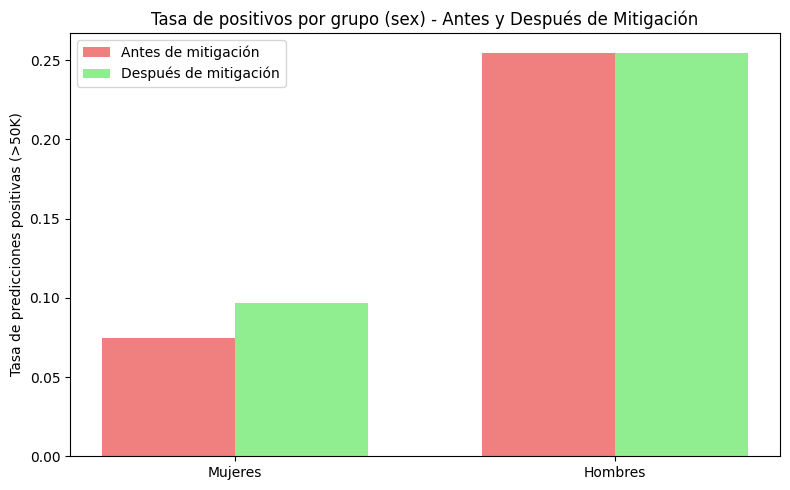

In [ ]:
import matplotlib.pyplot as plt

# Datos antes de mitigación
rates_before = [y_pred[female_idx].mean(), y_pred[male_idx].mean()]
# Datos después de mitigación
rates_after = [y_pred_adjusted[female_idx].mean(), y_pred_adjusted[male_idx].mean()]

groups = ['Mujeres', 'Hombres']
x = np.arange(len(groups))  # Posiciones de las barras

fig, ax = plt.subplots(figsize=(8, 5))
width = 0.35

ax.bar(x - width/2, rates_before, width, label='Antes de mitigación', color='lightcoral')
ax.bar(x + width/2, rates_after, width, label='Después de mitigación', color='lightgreen')

ax.set_ylabel('Tasa de predicciones positivas (>50K)')
ax.set_title('Tasa de positivos por grupo (sex) - Antes y Después de Mitigación')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()

plt.tight_layout()
plt.show()

### Gráfica 2: Disparate Impact (mujeres/hombres) antes y después
Muestra cómo se acerca a 1.0 (ideal) tras la mitigación.

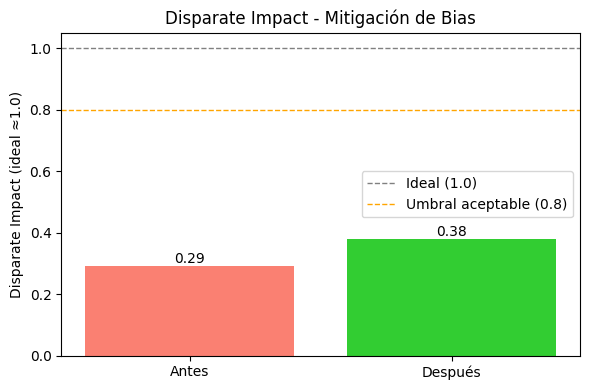

In [ ]:

di_before = y_pred[female_idx].mean() / y_pred[male_idx].mean() if y_pred[male_idx].mean() > 0 else 0
di_after = y_pred_adjusted[female_idx].mean() / y_pred_adjusted[male_idx].mean() if y_pred_adjusted[male_idx].mean() > 0 else 0

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Antes', 'Después'], [di_before, di_after], color=['salmon', 'limegreen'])

ax.set_ylabel('Disparate Impact (ideal ≈1.0)')
ax.set_title('Disparate Impact - Mitigación de Bias')
ax.axhline(1.0, color='gray', linestyle='--', linewidth=1, label='Ideal (1.0)')
ax.axhline(0.8, color='orange', linestyle='--', linewidth=1, label='Umbral aceptable (0.8)')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

ax.legend()
plt.tight_layout()
plt.show()

### Gráfica 3: Accuracy antes y después de mitigación
Muestra el pequeño trade-off (pérdida mínima de precisión por ganancia en fairness).

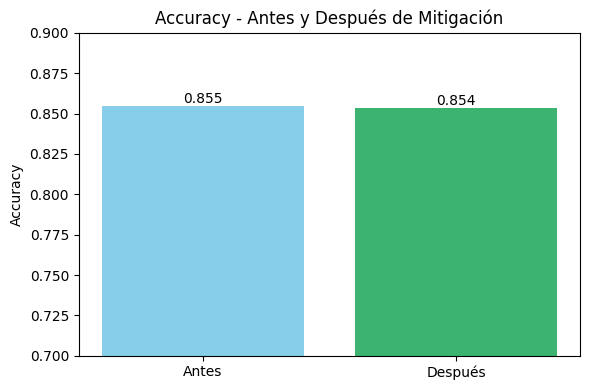

In [ ]:
acc_before = np.mean(y_pred == y_test)
acc_after = np.mean(y_pred_adjusted == y_test)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Antes', 'Después'], [acc_before, acc_after], color=['skyblue', 'mediumseagreen'])

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy - Antes y Después de Mitigación')
ax.set_ylim(0.7, 0.9)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Conclusión del proyecto

Este notebook implementa lo esencial del curso **Responsible AI for Developers: Fairness & Bias** de Google Cloud Skills Boost:

- Modelo base de clasificación con Logistic Regression  
- Métricas básicas de fairness por grupo protegido (`sex`)  
- Mitigación simple con post-processing (ajuste de threshold)  

Todo ejecutado en Colab gratuito, sin conflictos de dependencias ni cuenta GCP.

Proyecto inspirado en el curso y alineado con tu serie Responsible AI: detección → mitigación → métricas → fairness práctica.


#ResponsibleAI #Fairness #BiasMitigation #MachineLearning #GoogleCloud